# Smoothing Required for a Good Coarsening $P$
We expect to need smoother TVs for $P$ than for $R$.

In [1]:
%run /Users/olivne/helmholtz/src/helmholtz/startup.ipy

In [2]:
# Fixed seed for reproducible results.
np.random.seed(2)

# Domain size.
n = 96 # 192
domain_size = n   # With meshsize h = 1.
# Scaled wave number. Fit so lam_min = 0 (integer # periods in domain).
discretization = "5-point"
#kh = 0
kh = helmholtz.analysis.ideal.find_singular_kh(discretization, n)[0]
#kh = 0.5

repetitive = True

# Test vectors.
ideal_tv = False    # Use eigenvectors or not.
# Number of test vectors.  
num_examples = 3

# Set # sweeps manually here.
num_sweeps_on_vectors = 30 # 100 # None
threshold = 0.1

# Boottstrapping parameters.
interpolation_method = "ls" # "weighted_ls" #"ls"
fit_scheme = "ridge"
weighted = True
neighborhood = "extended" #"aggregate" # "extended"
num_test_examples = 5
leeway_factor = 1.3

_LOGGER.info("kh {}".format(kh))

INFO     kh 0.5233853805513015


## Level 0->1 Coarsening

In [3]:
# Create fine-level matrix.
a = hm.linalg.helmholtz_1d_discrete_operator(kh, discretization, n).tocsr()
# Use default = Kacmzarz relaxation for kh != 0.
level0 = hm.setup.hierarchy.create_finest_level(a,  relaxer=hm.solve.relax.GsRelaxer(a) if kh == 0 else None)
# 'location' is an array of variable locations at all levels. Used only for interpolation neighbor determination.
# Finest-level variable ocations are assumed to be [0..n-1], i.e. a domain of size n with meshsize h = 1.
level0.location = np.arange(n)

### Coarsening

In [4]:
def create_coarsening(level, nu, aggregate_size, num_components):
    # Generate relaxed test vectors.
    x = hm.setup.auto_setup.get_test_matrix(level.a, nu, num_examples=num_examples)
    _LOGGER.info("Generating relaxed TF with {} sweeps, RER {:.3f}".format(nu, norm(level.a.dot(x)) / norm(x)))
    #x_log.append(x)

    # Create coarsening. Force 2 coarse vars per aggregate so we can test alignment.
    r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False)
    R = r.tile(level.size // aggregate_size)
    return x, R

In [5]:
# Check Relaxation smoothing.
num_sweeps = hm.setup.auto_setup.check_relaxation_speed(0, level0)[1]
aggregate_size, num_components = 4, 2
x, R = create_coarsening(level0, 2 * num_sweeps, aggregate_size, num_components)

INFO     level 0 size 96 relax conv 0.93 shrinkage 0.64 PODR RER 0.55 after 5 sweeps. Work 1.0 eff 0.64
INFO     Generating relaxed TF with 10 sweeps, RER 0.336


### Coarsening Performance
Mock cycle convergnce factors below are shown as a function of
* Table = $\nu$ = number of relaxations per coarse-level correction in the mock cycle.
* Rows = $\nu_{TF}$ = number of relaxations performed on TFs.
* Columns = $s$ = number of samples (windows) used in SVD.

In [6]:
def mock_cycle_conv(level,
                    aggregate_size: int,
                    num_components: int,
                    num_cycle_sweeps: np.ndarray,
                    num_tf_sweeps: int,
                    num_windows: int,
                    seed: int = 0,
                    weighted: bool = True):  # List[Tuple[caliber: int, r_restrict: int, symmetrize: int]] 
    np.random.seed(seed)
    # Create test functions.
    x = hm.analysis.ideal.ideal_tv(level.a, num_examples)[0] if num_tf_sweeps == -1 \
                          else hm.setup.auto_setup.get_test_matrix(level.a, num_tf_sweeps, num_examples=num_examples)
    
    # Create R, measure mock cycle rates.
    r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False, 
                                                    num_windows=num_windows)
    R = r.tile(level.size // aggregate_size)
    return [hm.setup.auto_setup.mock_cycle_conv_factor(level, R, nu) for nu in num_cycle_sweeps]

In [7]:
seed = 0
num_cycle_sweeps = np.arange(1, num_sweeps + 4)
num_tf_sweeps = np.concatenate(([0], 2 ** np.arange(1, 7)))
num_windows = np.concatenate(([2, 3], 2 ** np.arange(2, 8)))
mock_conv = np.array([[mock_cycle_conv(
    level0, aggregate_size, num_components, num_cycle_sweeps,
    nu, s, weighted=weighted, seed=seed)
                for s in num_windows]
                for nu in num_tf_sweeps])

for col, nu_cycle in enumerate(num_cycle_sweeps):
    print("# Relax per cycle {}".format(nu_cycle))
    display(pd.DataFrame(mock_conv[:, :, col], index=num_tf_sweeps, columns=num_windows))

# Relax per cycle 1


,2,3,4,8,16,32,64,128
0,0.6099,0.7196,0.7028,0.9243,0.9333,0.9253,0.9172,0.9169
2,0.8538,0.6706,0.8386,0.9234,0.6717,0.6316,0.6228,0.6182
4,0.9246,0.6459,0.6486,0.6501,0.6307,0.6237,0.6251,0.6231
8,0.9271,0.6198,0.6217,0.6151,0.6149,0.6117,0.6084,0.6082
16,0.5227,0.6405,0.6045,0.6056,0.6088,0.6053,0.6046,0.6046
32,0.5909,0.6162,0.6076,0.6038,0.6034,0.6029,0.6031,0.6030
64,0.6051,0.6083,0.5972,0.5994,0.6005,0.6019,0.6029,0.6027


# Relax per cycle 2


,2,3,4,8,16,32,64,128
0,0.4379,0.6155,0.5247,0.9121,0.9175,0.8955,0.8985,0.8968
2,0.8354,0.5872,0.8372,0.9087,0.3089,0.3299,0.3193,0.3138
4,0.9171,0.3116,0.3222,0.3246,0.3303,0.3222,0.3254,0.3232
8,0.9206,0.2973,0.3040,0.3156,0.3116,0.3151,0.3173,0.3167
16,0.4659,0.5853,0.3290,0.3225,0.3183,0.3209,0.3228,0.3226
32,0.3586,0.3080,0.3244,0.3205,0.3216,0.3256,0.3266,0.3264
64,0.3310,0.3175,0.3318,0.3266,0.3259,0.3290,0.3291,0.3286


# Relax per cycle 3


,2,3,4,8,16,32,64,128
0,0.4889,0.6911,0.6236,0.8998,0.9059,0.8863,0.8839,0.8833
2,0.8536,0.6667,0.8560,0.9110,0.1595,0.1624,0.1732,0.1776
4,0.9154,0.3199,0.2038,0.2038,0.1694,0.1733,0.1707,0.1715
8,0.9153,0.4210,0.2195,0.1917,0.1908,0.1888,0.1932,0.1929
16,0.5492,0.6637,0.2077,0.2167,0.1971,0.1982,0.1996,0.1995
32,0.2381,0.2194,0.2031,0.2062,0.2017,0.2026,0.2028,0.2029
64,0.2727,0.2101,0.2120,0.2095,0.2057,0.2056,0.2044,0.2044


# Relax per cycle 4


,2,3,4,8,16,32,64,128
0,0.5132,0.6759,0.6128,0.8978,0.8987,0.8921,0.8851,0.8818
2,0.8166,0.6480,0.8115,0.8620,0.1678,0.1489,0.1455,0.1449
4,0.8666,0.3710,0.2574,0.2608,0.1428,0.1409,0.1421,0.1428
8,0.8651,0.4579,0.2569,0.1436,0.1505,0.1416,0.1432,0.1440
16,0.5551,0.6400,0.1531,0.1964,0.1486,0.1454,0.1446,0.1449
32,0.1416,0.2257,0.1507,0.1680,0.1520,0.1460,0.1443,0.1449
64,0.2962,0.1870,0.1537,0.1627,0.1527,0.1464,0.1434,0.1444


# Relax per cycle 5


,2,3,4,8,16,32,64,128
0,0.4535,0.6389,0.5775,0.8506,0.8544,0.8392,0.8383,0.8355
2,0.8027,0.6197,0.8016,0.8527,0.1861,0.1540,0.1489,0.1473
4,0.8584,0.3146,0.2205,0.2231,0.1505,0.1480,0.1493,0.1491
8,0.8606,0.3991,0.2097,0.1452,0.1475,0.1450,0.1454,0.1457
16,0.5069,0.6183,0.1460,0.1647,0.1457,0.1453,0.1452,0.1453
32,0.1466,0.1869,0.1456,0.1509,0.1468,0.1451,0.1447,0.1448
64,0.2368,0.1592,0.1480,0.1495,0.1470,0.1448,0.1440,0.1443


# Relax per cycle 6


,2,3,4,8,16,32,64,128
0,0.4389,0.6344,0.5730,0.8298,0.8338,0.8181,0.8152,0.8145
2,0.7944,0.6150,0.7976,0.8523,0.1749,0.1318,0.1286,0.1281
4,0.8578,0.3040,0.1788,0.1813,0.1306,0.1277,0.1284,0.1281
8,0.8609,0.3911,0.1727,0.1288,0.1305,0.1278,0.1288,0.1290
16,0.5027,0.6126,0.1320,0.1404,0.1303,0.1298,0.1297,0.1298
32,0.1340,0.1528,0.1312,0.1344,0.1316,0.1303,0.1298,0.1300
64,0.2228,0.1387,0.1327,0.1340,0.1321,0.1306,0.1297,0.1300


# Relax per cycle 7


,2,3,4,8,16,32,64,128
0,0.4491,0.6242,0.5678,0.8263,0.8299,0.8187,0.8104,0.8089
2,0.7784,0.6093,0.7810,0.8278,0.1445,0.0947,0.0913,0.0901
4,0.8324,0.3146,0.1853,0.1902,0.0955,0.0918,0.0922,0.0916
8,0.8315,0.3982,0.1837,0.0908,0.0906,0.0898,0.0901,0.0901
16,0.5026,0.6095,0.0932,0.1250,0.0904,0.0903,0.0905,0.0905
32,0.0986,0.1563,0.0931,0.0952,0.0927,0.0907,0.0908,0.0908
64,0.2344,0.1141,0.0937,0.0932,0.0929,0.0910,0.0909,0.0909


# Relax per cycle 8


,2,3,4,8,16,32,64,128
0,0.4336,0.6107,0.5532,0.8170,0.8203,0.7998,0.7942,0.7925
2,0.7570,0.5919,0.7599,0.8113,0.1135,0.0544,0.0558,0.0569
4,0.8174,0.3055,0.1820,0.1862,0.0550,0.0553,0.0549,0.0553
8,0.8212,0.3879,0.1816,0.0609,0.0655,0.0598,0.0622,0.0625
16,0.4893,0.5882,0.0740,0.1203,0.0663,0.0652,0.0653,0.0654
32,0.0790,0.1511,0.0702,0.0895,0.0725,0.0674,0.0662,0.0668
64,0.2254,0.1099,0.0771,0.0850,0.0744,0.0685,0.0660,0.0665


As can be seen, even two relaxation sweps are sufficient to obtain a good coarsening, if there are enough samples; or, relaxing more (at least 8 sweeeps) with only 4 (!) windows is enough to good coarsening.

In [8]:
for l, nu in enumerate(num_cycle_sweeps):
    ideal = mock_conv[-1, -1, l]
    i, j = np.where(mock_conv[:, :, l] < 1.3 * ideal)
    work = np.maximum(num_tf_sweeps[i], 1) * num_windows[j]
    best = np.argmin(work)
    print(nu, num_tf_sweeps[i[best]], num_windows[j[best]], work[best], mock_conv[i[best], j[best], l])

1 0 2 2 0.609901516411503
2 4 3 12 0.3115568450997314
3 4 4 16 0.20379672261801585
4 2 16 32 0.16784444647705046
5 2 16 32 0.18607808745722723
6 2 32 64 0.13179046913572132
7 2 32 64 0.09465602273418183
8 2 32 64 0.05435295835099124


### Interpolation Performance

In [9]:
def two_level_performance(level, 
                          aggregate_size: int,
                          num_components: int,
                          max_cycle_sweeps: int,
                          num_tf_sweeps: int,
                          num_windows: int,
                          coarsening_types,
                          seed: int = 0,
                          weighted: bool = True):  # List[Tuple[caliber: int, r_restrict: int, symmetrize: int]] 
    np.random.seed(seed)
    num_cycle_sweeps = np.arange(1, max_cycle_sweeps + 1)
    # Create test functions.
    if num_tf_sweeps == -1:
        x = hm.analysis.ideal.ideal_tv(level.a, num_examples)[0]
    else:
        x = hm.setup.auto_setup.get_test_matrix(level.a, num_tf_sweeps, num_examples=num_examples)
    
    # Create R, measure mock cycle rates.
    r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False, num_windows=num_windows)
    R = r.tile(level.size // aggregate_size)
    # TODO: replace by local mock cycle rate.
    mock_conv = np.array([hm.setup.auto_setup.mock_cycle_conv_factor(level, R, nu) for nu in num_cycle_sweeps])

    l2c = []
    p_values = []
    for caliber, r_restrict, symmetrize in coarsening_types:
        # Create P, A^c, and a two-level hierarchy.
        p = hm.setup.auto_setup.create_interpolation(
            x, level.a, R, level.location, domain_size, interpolation_method, aggregate_size=aggregate_size, num_components=num_components, 
            neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
            caliber=caliber, fit_scheme=fit_scheme, weighted=weighted, num_windows=num_windows)
        ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
                level.a, level.location, R, p, aggregate_size, num_components,
            use_r_as_restriction=r_restrict, symmetrize=symmetrize)
        
        # Measure convergence and operator stats.
        ac = ml[1].a
        fill_in_factor = (ac.nnz / ml[0].a.nnz) * (ml[0].a.shape[0] / ac.shape[0])
        symmetry_deviation = np.max(np.abs(ac - ac.transpose()))
        two_level_conv = np.array([
            hm.repetitive.locality.two_level_conv_factor(
                ml, nu, print_frequency=None)[1]
             for nu in num_cycle_sweeps])
        l2c.append([False, caliber, r_restrict, symmetrize, p.nnz, fill_in_factor, symmetry_deviation] + list(two_level_conv))
        p_values.append(p)
    return pd.DataFrame(np.array([[True, 0, False, False, 0, 0, False] + list(mock_conv)] + l2c),
        columns=("mock", "caliber", "r-restrict", "symmetrize", "nnz(P)", "Fill-in", "Symmetry") + tuple(num_cycle_sweeps)).astype(
        {"mock": bool, "caliber": int, "r-restrict": bool, "symmetrize": bool, "nnz(P)": int}), x, R, p_values

In [10]:
num_tf_sweeps = np.concatenate(([0], 2 ** np.arange(1, 7)))
num_windows = 64
coarsening_types = [
    (4, False, False),
    (4, True, False),
    (4, True, True)
]

# seed=13 - RAP symmetrized strongly diverges.
seed = 14
#for seed in range(13, 14):
#    print("seed", seed)
for num_tf_sweeps in np.concatenate(([-1], [0], 2 ** np.arange(1, 10))):
    print("num_tf_sweeps", num_tf_sweeps)
    conv, x, R, p_values = two_level_performance(level0, aggregate_size, num_components, num_sweeps + 3,
                                                 num_tf_sweeps, num_windows, coarsening_types, 
                                                 weighted=weighted, seed=seed)
    display(conv)

num_tf_sweeps -1


,mock,caliber,r-restrict,symmetrize,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8
0,True,0,False,False,0,0.0000,0.0000,0.5786,0.3136,0.1956,0.1384,0.1459,0.1283,0.0877,0.0629
1,False,4,False,False,384,2.0000,0.0000,0.6082,0.3286,0.1996,0.1482,0.1521,0.1366,0.0987,0.0705
2,False,4,True,False,384,1.2000,0.0030,1.1475,0.5242,0.4837,0.4969,0.4780,0.4885,0.4632,0.5382
3,False,4,True,True,384,1.2000,0.0000,7.1279,5.0469,4.7942,2.4632,2.1174,2.5040,2.3345,2.0041


num_tf_sweeps 0


,mock,caliber,r-restrict,symmetrize,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8
0,True,0,False,False,0,0.0000,0.0000,0.9488,0.9123,0.8986,0.8722,0.8586,0.8323,0.8329,0.8049
1,False,4,False,False,384,2.0000,0.0000,0.9856,0.9708,0.9569,0.9476,0.9317,0.9441,0.9283,0.9388
2,False,4,True,False,384,1.2000,0.4587,0.9870,0.9738,0.9570,0.9485,0.9421,0.9156,0.9538,0.9388
3,False,4,True,True,384,1.2000,0.0000,0.9879,0.9746,0.9633,0.9472,0.9431,0.9301,0.9168,0.9357


num_tf_sweeps 2


,mock,caliber,r-restrict,symmetrize,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8
0,True,0,False,False,0,0.0000,0.0000,0.6358,0.2965,0.1593,0.1465,0.1542,0.1395,0.1100,0.0778
1,False,4,False,False,384,2.0000,0.0000,3.1325,4.7702,4.5444,4.1966,3.8334,3.9329,4.1364,4.2310
2,False,4,True,False,384,1.2000,0.0558,1.7411,2.0245,2.2516,2.0705,1.8894,1.9335,1.9914,2.0300
3,False,4,True,True,384,1.2000,0.0000,46.6502,43.3795,36.7184,31.6418,30.6173,33.0897,34.8300,35.1185


num_tf_sweeps 4


,mock,caliber,r-restrict,symmetrize,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8
0,True,0,False,False,0,0.0000,0.0000,0.6000,0.3104,0.1713,0.1430,0.1410,0.1295,0.0872,0.0567
1,False,4,False,False,384,2.0000,0.0000,0.6586,0.5239,0.3772,0.3100,0.3003,0.2869,0.2751,0.2781
2,False,4,True,False,384,1.2000,0.0264,0.7524,0.4201,0.3472,0.3200,0.3349,0.2966,0.2436,0.1935
3,False,4,True,True,384,1.2000,0.0000,0.7544,0.4144,0.3210,0.2911,0.3119,0.2916,0.2465,0.1981


num_tf_sweeps 8


,mock,caliber,r-restrict,symmetrize,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8
0,True,0,False,False,0,0.0000,0.0000,0.5909,0.3209,0.1811,0.1436,0.1392,0.1296,0.0871,0.0591
1,False,4,False,False,384,2.0000,0.0000,0.6046,0.3168,0.1590,0.1338,0.1408,0.1563,0.1216,0.0736
2,False,4,True,False,384,1.2000,0.0172,0.8646,0.4764,0.2718,0.2003,0.2189,0.2009,0.1634,0.1305
3,False,4,True,True,384,1.2000,0.0000,0.8567,0.4713,0.3137,0.2189,0.2186,0.2021,0.1649,0.1232


num_tf_sweeps 16


,mock,caliber,r-restrict,symmetrize,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8
0,True,0,False,False,0,0.0000,0.0000,0.5861,0.3249,0.1891,0.1444,0.1385,0.1298,0.0865,0.0626
1,False,4,False,False,384,2.0000,0.0000,0.6025,0.3288,0.1879,0.1295,0.1427,0.1353,0.1017,0.0629
2,False,4,True,False,384,1.2000,0.0037,1.4244,0.5427,0.4641,0.2014,0.1993,0.1603,0.1214,0.0906
3,False,4,True,True,384,1.2000,0.0000,1.5163,0.5082,0.4895,0.1810,0.2010,0.1640,0.1272,0.0873


num_tf_sweeps 32


,mock,caliber,r-restrict,symmetrize,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8
0,True,0,False,False,0,0.0000,0.0000,0.5844,0.3263,0.1929,0.1433,0.1376,0.1296,0.0868,0.0636
1,False,4,False,False,384,2.0000,0.0000,0.6009,0.3317,0.1990,0.1345,0.1479,0.1372,0.1035,0.0677
2,False,4,True,False,384,1.2000,0.0054,1.9011,0.5267,0.5340,0.2198,0.2095,0.1695,0.1270,0.0950
3,False,4,True,True,384,1.2000,0.0000,7.5294,1.2678,2.5048,0.6299,0.6619,0.2403,0.2285,0.1509


num_tf_sweeps 64


,mock,caliber,r-restrict,symmetrize,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8
0,True,0,False,False,0,0.0000,0.0000,0.5835,0.3266,0.1940,0.1434,0.1376,0.1296,0.0868,0.0639
1,False,4,False,False,384,2.0000,0.0000,0.6020,0.3302,0.2032,0.1394,0.1522,0.1367,0.1012,0.0707
2,False,4,True,False,384,1.2000,0.0024,2.7605,0.6553,0.8846,0.2561,0.2105,0.1566,0.1197,0.0881
3,False,4,True,True,384,1.2000,0.0000,2.7302,0.7030,0.7977,0.2826,0.1976,0.1611,0.1187,0.0864


num_tf_sweeps 128


,mock,caliber,r-restrict,symmetrize,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8
0,True,0,False,False,0,0.0000,0.0000,0.5831,0.3271,0.1945,0.1410,0.1366,0.1295,0.0877,0.0627
1,False,4,False,False,384,2.0000,0.0000,0.6019,0.3303,0.2036,0.1395,0.1517,0.1373,0.1033,0.0702
2,False,4,True,False,384,1.2000,0.0079,1.2754,0.5389,0.3947,0.2173,0.2145,0.1719,0.1277,0.0932
3,False,4,True,True,384,1.2000,0.0000,6.0618,0.7715,2.0086,0.4347,0.5374,0.1742,0.2027,0.1343


num_tf_sweeps 256


,mock,caliber,r-restrict,symmetrize,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8
0,True,0,False,False,0,0.0000,0.0000,0.5830,0.3273,0.1948,0.1403,0.1363,0.1295,0.0879,0.0626
1,False,4,False,False,384,2.0000,0.0000,0.5933,0.3406,0.2708,0.1311,0.1436,0.1459,0.1143,0.0727
2,False,4,True,False,384,1.2000,0.0086,1.7699,0.5385,0.4447,0.2590,0.2419,0.1962,0.1497,0.1149
3,False,4,True,True,384,1.2000,0.0000,6.7824,1.5499,2.5352,0.8523,0.4764,0.3355,0.2861,0.4021


num_tf_sweeps 512


,mock,caliber,r-restrict,symmetrize,nnz(P),Fill-in,Symmetry,1,2,3,4,5,6,7,8
0,True,0,False,False,0,0.0000,0.0000,0.5828,0.3274,0.1950,0.1403,0.1363,0.1295,0.0880,0.0626
1,False,4,False,False,384,2.0000,0.0000,0.5948,0.3377,0.2168,0.1308,0.1423,0.1472,0.1151,0.0702
2,False,4,True,False,384,1.2000,0.0073,1.2047,0.5335,0.3912,0.2567,0.2413,0.1973,0.1507,0.1161
3,False,4,True,True,384,1.2000,0.0000,1.7546,0.5286,0.4493,0.2432,0.2358,0.1961,0.1598,0.1158


With $s = 32$ windows:
8 $P^T A P$ gives good rated with with only $4$ TF sweeps. 
* $8$ are required to get a good $R A P$.
* Symmetrizing $R A P$ requires at least $32$ sweeps, although even then the cycle diverges for $\nu=1$. But it also diverges for $R A P$, so symmetrizing is not necessarily the culprit; it just amplifies divergece when it's present.

One idea is to employ two-level bootstrap with $P^T A P$ and only at the end of processing 

#### Symmetrized $R A P$ Performance vs. $\nu_{TF}, s$

In [11]:
def two_level_conv(level, 
                    aggregate_size: int,
                    num_components: int,
                    num_cycle_sweeps: np.ndarray,
                    num_tf_sweeps: int,
                    num_windows: int,
                    coarsening_type,
                    seed: int = 0,
                    weighted: bool = True):  # List[Tuple[caliber: int, r_restrict: int, symmetrize: int]] 
    np.random.seed(seed)
    # Create test functions.
    x = hm.analysis.ideal.ideal_tv(level.a, num_examples)[0] if nu == -1 \
                          else hm.setup.auto_setup.get_test_matrix(level.a, num_tf_sweeps, num_examples=num_examples)
    
    # Create R, measure mock cycle rates.
    r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False, 
                                                    num_windows=num_windows)
    R = r.tile(level.size // aggregate_size)

    caliber, r_restrict, symmetrize = coarsening_type
    # Create P, A^c, and a two-level hierarchy.
    p = hm.setup.auto_setup.create_interpolation(
        x, level.a, R, level.location, domain_size, interpolation_method, aggregate_size=aggregate_size, num_components=num_components, 
        neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
        caliber=caliber, fit_scheme=fit_scheme, weighted=weighted, num_windows=num_windows)
    ml = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
            level.a, level.location, R, p, aggregate_size, num_components,
        use_r_as_restriction=r_restrict, symmetrize=symmetrize)

    return[
        hm.repetitive.locality.two_level_conv_factor(
            ml, nu, print_frequency=None)[1]
         for nu in num_cycle_sweeps]

In [12]:
num_cycle_sweeps = np.arange(1, num_sweeps + 4)
num_tf_sweeps = np.concatenate(([0], 2 ** np.arange(1, 7)))
num_windows = 2 ** np.arange(4, 8)

coarsening_type = (4, True, True)

conv = np.array([[two_level_conv(
    level0, aggregate_size, num_components, num_cycle_sweeps,
        nu, s, coarsening_type, weighted=weighted, seed=seed)
                for s in num_windows]
                for nu in num_tf_sweeps])

for col, nu_cycle in enumerate(num_cycle_sweeps):
    print("# Relax per cycle {}".format(nu_cycle))
    display(pd.DataFrame(conv[:, :, col], index=num_tf_sweeps, columns=num_windows))

# Relax per cycle 1


,16,32,64,128
0,1.0496,0.9837,0.9874,0.9925
2,17.1117,32.6091,46.7050,2.5195
4,7.9202,0.8712,0.7580,0.7568
8,1.9778,1.0103,0.8801,0.8568
16,102.1168,2.0185,1.5202,3.1406
32,4.9637,1.2290,7.5430,5.2378
64,53.8796,3.2493,2.7299,7.2587


# Relax per cycle 2


,16,32,64,128
0,1.0081,0.9691,0.9737,0.9789
2,11.3100,25.3375,43.4365,3.6132
4,7.3915,0.8900,0.4154,0.3863
8,0.7433,0.4779,0.5040,0.4907
16,87.5268,0.6013,0.5393,0.6543
32,3.1160,0.4501,1.2668,0.6066
64,5.3514,0.7090,0.7041,1.4629


# Relax per cycle 3


,16,32,64,128
0,0.9741,0.9557,0.9597,0.9662
2,13.8931,29.9690,36.8732,3.0887
4,5.8985,0.5389,0.3140,0.2827
8,0.5416,0.3019,0.3059,0.2880
16,60.5611,0.5414,0.4863,0.8813
32,2.0130,0.2704,2.4895,1.5881
64,13.8705,0.8620,0.7872,2.2960


# Relax per cycle 4


,16,32,64,128
0,0.9628,0.9491,0.9534,0.9564
2,11.2803,26.0317,31.6784,2.6293
4,6.7239,0.3443,0.2914,0.2483
8,0.6885,0.1985,0.2193,0.1994
16,65.7332,0.2029,0.1986,0.2789
32,2.3395,0.2995,0.6351,0.3382
64,12.7182,0.3558,0.2824,0.6102


# Relax per cycle 5


,16,32,64,128
0,0.9441,0.9353,0.9376,0.9423
2,10.5972,23.9378,30.3643,2.4548
4,6.5803,0.4103,0.3202,0.2695
8,0.6721,0.1984,0.2304,0.2126
16,68.9063,0.2127,0.2048,0.2633
32,2.3588,0.2464,0.6630,0.3854
64,7.7851,0.2424,0.2037,0.4806


# Relax per cycle 6


,16,32,64,128
0,0.9304,0.9206,0.9260,0.9298
2,9.7759,23.8541,33.0482,2.5742
4,6.2248,0.4499,0.2926,0.2443
8,0.5203,0.1679,0.2026,0.1845
16,65.9594,0.1540,0.1603,0.1640
32,2.2024,0.1622,0.2345,0.1809
64,8.8362,0.1593,0.1575,0.3302


# Relax per cycle 7


,16,32,64,128
0,0.9291,0.9300,0.9322,0.9350
2,9.4736,23.8782,34.8534,2.7934
4,6.3043,0.4383,0.2440,0.1993
8,0.5430,0.1308,0.1612,0.1453
16,64.0764,0.1055,0.1227,0.1268
32,2.2065,0.1237,0.2311,0.1619
64,7.5368,0.1182,0.1139,0.2484


# Relax per cycle 8


,16,32,64,128
0,0.9310,0.9392,0.9410,0.9427
2,9.6236,24.6394,35.1272,2.8817
4,6.3308,0.4110,0.1947,0.1545
8,0.5201,0.0937,0.1209,0.1071
16,63.1344,0.0973,0.0888,0.0915
32,2.0532,0.1115,0.1422,0.1061
64,5.5953,0.0846,0.0883,0.1328


In [13]:
for l, nu in enumerate(num_cycle_sweeps):
    ideal = conv[-1, -1, l]
    i, j = np.where(conv[:, :, l] < 1.3 * ideal)
    work = np.maximum(num_tf_sweeps[i], 1) * num_windows[j]
    best = np.argmin(work)
    print(nu, num_tf_sweeps[i[best]], num_windows[j[best]], work[best], mock_conv[i[best], j[best], l])

1 0 16 16 0.609901516411503
2 0 16 16 0.4378622242607565
3 0 16 16 0.48886645524803696
4 4 32 128 0.37096656140705675
5 4 32 128 0.3146038558636472
6 4 64 256 0.17882696867587353
7 4 64 256 0.18525178760568653
8 8 32 256 0.38788463845497523


## Notes
* The product of smoothing * samples is still the important factor for good convergence.
* Looks like adding windows is more beneficial than adding smoothing.

### Create Level 1

INFO         0 |r| 1.570e+01 RER 2.86622
INFO         1 |r| 2.154e+00 (0.13717) RER 0.01545 (0.00539) 139.369
INFO         2 |r| 3.031e-01 (0.14072) RER 0.00225 (0.14569) 134.614
INFO         3 |r| 5.624e-02 (0.18553) RER 0.00042 (0.18835) 132.601
INFO         4 |r| 1.162e-02 (0.20666) RER 0.00009 (0.20605) 132.994
INFO         5 |r| 2.620e-03 (0.22543) RER 0.00002 (0.22552) 132.939
INFO         6 |r| 6.162e-04 (0.23519) RER 0.00000 (0.23520) 132.936
INFO         7 |r| 1.488e-04 (0.24156) RER 0.00000 (0.24156) 132.938
INFO         8 |r| 3.628e-05 (0.24372) RER 0.00000 (0.24372) 132.938
INFO         9 |r| 8.870e-06 (0.24451) RER 0.00000 (0.24451) 132.938
INFO        10 |r| 2.175e-06 (0.24517) RER 0.00000 (0.24517) 132.938
INFO        11 |r| 5.336e-07 (0.24538) RER 0.00000 (0.24538) 132.938
INFO        12 |r| 1.307e-07 (0.24500) RER 0.00000 (0.24500) 132.938
INFO        13 |r| 3.191e-08 (0.24412) RER 0.00000 (0.24412) 132.938
INFO        14 |r| 7.756e-09 (0.24303) RER 0.00000 (0.24303) 1

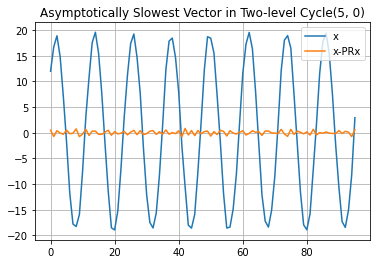

In [14]:
# Pick an interpolation operator P:1->0 to work with. We use a high-order (caliber 4) P and RAP.

caliber = 4
num_windows = None
use_r_as_restriction = True #False
symmetrize = True # False
nu_tf = 64

p = p_values[0]
# x = hm.analysis.ideal.ideal_tv(level0.a, num_examples)[0] if nu_tf == -1 \
#     else hm.setup.auto_setup.get_test_matrix(level0.a, nu_tf, num_examples=num_examples)

# # Create R, measure mock cycle rates.
# r, s = hm.repetitive.locality.create_coarsening(x, aggregate_size, num_components, normalize=False, num_windows=num_windows)
# R = r.tile(level0.size // aggregate_size)

# p = hm.setup.auto_setup.create_interpolation(
#     x, level0.a, R, level0.location, domain_size, interpolation_method, aggregate_size=aggregate_size, num_components=num_components, 
#     neighborhood=neighborhood, repetitive=repetitive, target_error=0.1,
#     caliber=caliber, fit_scheme=fit_scheme, weighted=weighted, num_windows=num_windows)

m0 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
    level0.a, level0.location, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction,
    symmetrize=symmetrize)

nu = 5
y, _ = hm.repetitive.locality.two_level_conv_factor(m0, nu, print_frequency=1, debug=False)

# Asymptotic vector.
plt.title("Asymptotically Slowest Vector in Two-level Cycle({}, 0)".format(nu))
# y -= y.mean() # Remove zero component.
e = y - m0[1].interpolate(m0[1].coarsen(y))
plt.plot(y, label="x");
plt.plot(e, label="x-PRx");

plt.grid(True);
plt.legend();

In [15]:
# Calculate eigenpairs at all levels.
laml, vl_finest = hm.analysis.ideal.compare_spectrum(m0)
for l, lam in enumerate(laml):
    print(l, "lam", np.array2string(lam[:12], precision=3))

0 lam [-0.     0.     0.064  0.064 -0.073 -0.073  0.12   0.12  -0.154 -0.154  0.167  0.167]
1 lam [-0.    -0.     0.064  0.064 -0.073 -0.073  0.118  0.118 -0.152 -0.152  0.163  0.163]


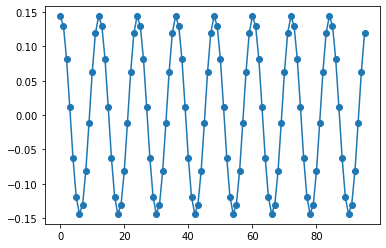

In [16]:
plt.plot(vl_finest[0][:, 0], '-o')

## TODO

* Try ideal vectors.
* Do relaxations to generate an initial $P$.
* Bootstrap is for identifying slow-to-converge components and improve $P$ for them.
* $8$ TF sweeps only - what is the initial cycle rate? Does it have good shrinkage? Even if asymptotic rate is bad.
* Compare first mock cycle rates vs. 2-level cycle rates.
* Check if divergence is because the last cycles ar bad but before were good.
* Add orthogonalization / Ritz projection - does the result improve with more relax sweeps then?
* Do we need to regularize?
* Try larger domain, at which # relax does the problem start? Is it domain size dependent?

In [17]:
# p = p_experiment[True][-1]

In [18]:
# # TODO(orenlivne): define error as (x-x0) projected onto range(a).
# nu = 2
# use_r_as_restriction = False
# p = p_experiment[use_r_as_restriction][-1]  # P^T*A*P P high order
# use_r_as_restriction = use_r_as_restriction

# m1 = hm.repetitive.locality.create_two_level_hierarchy_from_matrix(
#     level1.a, level1.location, R, p, aggregate_size, num_components, use_r_as_restriction=use_r_as_restriction)

# y, _ = hm.repetitive.locality.two_level_conv_factor(m1, nu, print_frequency=1,
#                                                     debug=False)

# # Asymptotic vector.
# plt.title("Asymptotically Slowest Vector in Two-level Cycle({},0)".format(nu))
# # y -= y.mean() # Remove zero component.
# e = y - m1[1].interpolate(m1[1].coarsen(y))
# plt.plot(y, label="x");
# plt.plot(e, label="x-PRx");
# plt.grid(True);
# plt.legend();